In [4]:
# import packages
import sys
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# load the dataset
df = pd.read_csv("../../DataSet/mnist_train.csv")

In [3]:
# input and output features
X = df.iloc[:,1:].to_numpy() / 255.0 # Normalizing between 0 to 1
Y = df.iloc[:,0].to_numpy()

In [5]:
# split into train and test data
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:], Y[:-1000], Y[-1000:]

In [6]:
# Shuffle the training data
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [7]:
# Show PIC func
def showPIC(x,y):
    plt.figure(figsize=(2,2))
    plt.title("Digit: "+str(y))
    plt.imshow(x.reshape(28,28))
    plt.show()

<IPython.core.display.Javascript object>


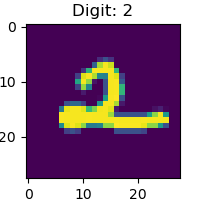

In [8]:
# Testing a PIC
pic_id = 1
showPIC(Xtrain[pic_id], Ytrain[pic_id])

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

In [11]:
def relu(z):
    return z*(z>0)

In [12]:
def softmax(z):
    return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

In [13]:
def oneHotEncode(y):
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))
    
    for i,val in enumerate(y):
        T[i,val] = 1
        
    return T

In [16]:
def nonlinearDr(z,activation):
    if activation=="sigmoid":
        return z*(1-z)
    if activation=="tanh":
        return (1-z**2)
    if activation=="relu":
        return (z>0)

In [14]:
def cost(t,y):
    return -np.sum(t*np.log(y))

In [19]:
def forward(X,T,hidden,activation,W,B,A,Vw,Vb,i,seed):
    D = X.shape[1]
    K = T.shape[1]
    L = len(hidden)
    
    for l in range(L+1):
        if l==0:
            if i==0:
                W[l] = np.random.randn(D,hidden[l])
                B[l] = np.random.randn(hidden[l])
                Vw[l] = 0
                Vb[l] = 0
            A[l] = activation(np.dot(X,W[l])+B[l])
            
        elif l==L:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],K)
                B[l] = np.random.randn(K)
                Vw[l] = 0
                Vb[l] = 0
            A[l] = softmax(np.dot(A[l-1],W[l])+B[l])
            Y = A[l]
            
        else:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],hidden[l])
                B[l] = np.random.randn(hidden[l])
                Vw[l] = 0
                Vb[l] = 0
            A[l] = activation(np.dot(A[l-1],W[l])+B[l])
    
    return W,B,A,Vw,Vb,Y

In [20]:
def backprop(X,T,Y,hidden,activation,lr,momentum,W,B,A,Vw,Vb):
    L = len(hidden)
    Err,Grad = {},{}
    
    for l in range(L,-1,-1):
        if l==L:
            Err[l] = T-Y
            Grad[l] = Err[l]
            
        else:
            Err[l] = np.dot(Grad[l+1],W[l+1].T)
            Grad[l] = Err[l]*nonlinearDr(A[l],activation.__name__)
            
    for l in range(L+1):
        if l==0:
            Vw[l] = lr * np.dot(X.T,Grad[l])
            Vb[l] = lr * Grad[l].sum(axis=0)
            W[l] += Vw[l]
            B[l] += Vb[l]
        else:
            Vw[l] = lr * np.dot(A[l-1].T, Grad[l])
            Vb[l] = lr * Grad[l].sum(axis=0)
            W[l] += Vw[l]
            B[l] += Vb[l]
            
    return W,B,Vw,Vb

In [21]:
def train(X,Ytrain,Xtest,Ytest,hidden,activation,iterations,lr,momentum,seed):
    T = oneHotEncode(Ytrain)
    Ttest = oneHotEncode(Ytest)
    W,B,A,Vw,Vb = {},{},{},{},{}
    Ctrain, Ctest = [],[]
    
    for i in range(iterations):
        W,B,A,Vw,Vb,Y = forward(X,T,hidden,activation,W,B,A,Vw,Vb,i,seed)
        W,B,Vw,Vb = backprop(X,T,Y,hidden,activation,lr,momentum,W,B,A,Vw,Vb)
        _,_,_,_,_,Y_test = forward(Xtest,Ttest,hidden,activation,W,B,A,Vw,Vb,i,seed)
        
        trCost = cost(T,Y)
        teCost = cost(Ttest,Y_test)
        
        Ctrain.append(trCost)
        Ctest.append(teCost)
        
        sys.stdout.write("\rIterations: {} | Training Cost: {} | Test Cost: {}".format(i+1, trCost, teCost))
        
    return Ctrain, Ctest, W, B, Vw, Vb, Y, Y_test